In [ ]:
import sys, os, math, random, itertools, pickle, logging, yaml, psutil
from collections import defaultdict
import concurrent.futures as cf
from tqdm import tqdm
from addict import Dict
import numpy as np, pandas as pd
sys.path.append('/workspace')
from tools.logger import add_stream_handler, get_logger
logger = get_logger()
add_stream_handler(logger, logging.DEBUG)

import matplotlib.pyplot as plt
from tools.graph import tightargs, errorbarargs, COLORS2, setfont2, get_scatter_style
setfont2()


sys.path.append("/workspace/cplm")

[250522 20:21:52][matplotlib][DEBUG]matplotlib data path: /workspace/envs/cu124/3.11.9/241/lib/python3.11/site-packages/matplotlib/mpl-data
[250522 20:21:52][matplotlib][DEBUG]CONFIGDIR=/home/creator2/.config/matplotlib
[250522 20:21:52][matplotlib][DEBUG]interactive is False
[250522 20:21:52][matplotlib][DEBUG]platform is linux
[250522 20:21:52][matplotlib][DEBUG]CACHEDIR=/home/creator2/.cache/matplotlib
[250522 20:21:52][matplotlib.font_manager][DEBUG]Using fontManager instance from /home/creator2/.cache/matplotlib/fontlist-v390.json


## 色々なデータセットの長さを比較

In [16]:
def draw_compare_length(datasets, labels, nbin, range, n_sample, save_path=None, seed=0):
    rng = np.random.default_rng(seed)
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    for idata, dataset in enumerate(datasets):
        L = len(dataset)
        if L > n_sample: idxs = rng.choice(L, size=n_sample, replace=False)
        else: idxs = np.arange(L, dtype=int)
        ls = [len(dataset[idx]) for idx in tqdm(idxs)]
        ax.hist(ls, bins=nbin, range=range, alpha=0.5, label=labels[idata])
    ax.set_xlim(range[0], range[1])
    ax.legend()
    if save_path is not None:
        fig.savefig(save_path, **tightargs)
    return fig, ax


100%|██████████| 1000/1000 [00:00<00:00, 3089.83it/s]


(<Figure size 700x500 with 1 Axes>, <Axes: >)

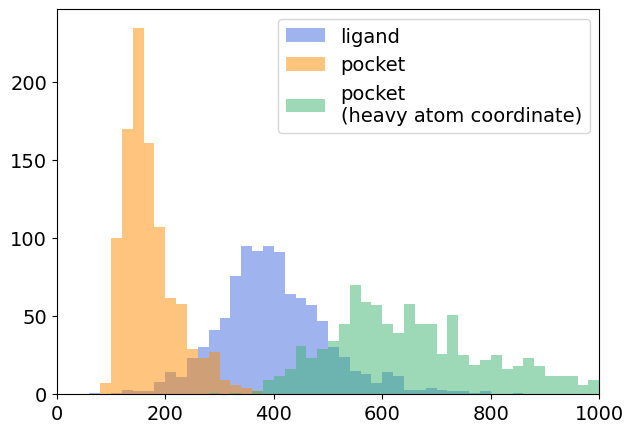

In [17]:
from src.data import UniMolLigandDataset, MoleculeDataset, UniMolPocketDataset, ProteinDataset
from src.data import CoordTransform, StringTokenizer, FloatTokenizer, ProteinAtomTokenizer
# LigandDataset, Pocket(coord_heavyなし)
coord_range = 250
tokenizer_log_interval = 1e6

coord_transform = CoordTransform(0, True, True, 50)
smiles_tokenizer = StringTokenizer(open("/workspace/cplm/src/data/smiles_tokens.txt").read().splitlines())
coord_tokenizer = FloatTokenizer(-coord_range, coord_range, log_interval=tokenizer_log_interval)
protein_atom_tokenizer = ProteinAtomTokenizer(log_interval=tokenizer_log_interval)

ligand = UniMolLigandDataset("/workspace/cheminfodata/unimol/ligands/train.lmdb", 10, atom_h=True)
ligand = MoleculeDataset(ligand, coord_transform, smiles_tokenizer, coord_tokenizer)


pocket_base = UniMolPocketDataset("/workspace/cheminfodata/unimol/pockets/train.lmdb", key_is_indexed=True)
pocket = ProteinDataset(pocket_base, protein_atom_tokenizer, coord_tokenizer, coord_transform, 
    atom_heavy=True, coord_heavy=False, atom_h=False, coord_h=False, )

pocket_coord_heavy = ProteinDataset(pocket_base, protein_atom_tokenizer, coord_tokenizer, coord_transform, 
    atom_heavy=True, coord_heavy=True, atom_h=False, coord_h=False, )

draw_compare_length([ligand, pocket, pocket_coord_heavy], ['ligand', 'pocket', 'pocket\n(heavy atom coordinate)'],
    50, (0, 1000), 1000)


## 241219 分割して処理したのを確認する。
... 大丈夫そうだった。

In [8]:
from src.utils.lmdb import load_lmdb
from rdkit import Chem

In [4]:

df = pd.read_csv("results/finetune/r4_all/filenames.csv", index_col=0)
dfs = df.sample(n=5, axis=0)
env, txn = load_lmdb("results/finetune/r4_all/main.lmdb")

In [17]:

for idx in dfs.index:
    data = pickle.loads(txn.get(str(idx).encode('ascii')))
    
    dname = dfs.loc[idx, 'dname']
    lname = dfs.loc[idx, 'lig_name']
    sdf_idx = dfs.loc[idx, 'sdf_idx']
    mol = list(Chem.SDMolSupplier(f"/workspace/cheminfodata/crossdocked/CrossDocked2020/{dname}/{lname}"))[sdf_idx]
    print(Chem.MolToSmiles(mol) == Chem.MolToSmiles(Chem.RemoveHs(data['lig_mol'])))

True
True
True
True


[21:08:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:08:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:08:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:08:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:08:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:08:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:08:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:08:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:08:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

True


In [16]:
print(Chem.MolToSmiles(mol))
print(Chem.MolToSmiles(Chem.RemoveHs(data['lig_mol'])))

Oc1cc(Cl)ccc1Oc1ccc(Cl)cc1Cl
Oc1cc(Cl)ccc1Oc1ccc(Cl)cc1Cl


In [13]:
df.head()

,dname,lig_name,protein_name,sdf_idx
idx,,,,
0,1433B_HUMAN_1_240_pep_0,2bq0_A_rec_5f74_amp_lig_it1_it2_tt_docked.sdf,2bq0_A_rec.pdb,1
1,1433B_HUMAN_1_240_pep_0,2bq0_A_rec_5f74_amp_lig_it1_it2_tt_docked.sdf,2bq0_A_rec.pdb,2
2,1433B_HUMAN_1_240_pep_0,2bq0_A_rec_5f74_amp_lig_it1_it2_tt_docked.sdf,2bq0_A_rec.pdb,3
3,1433B_HUMAN_1_240_pep_0,2bq0_A_rec_5f74_amp_lig_it1_it2_tt_docked.sdf,2bq0_A_rec.pdb,5
4,1433B_HUMAN_1_240_pep_0,2bq0_A_rec_5f74_amp_lig_it1_it2_tt_docked.sdf,2bq0_A_rec.pdb,6
